# TalkingData AdTracking Fraud Detection Challenge

### Description

Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. Ad channels can drive up costs by simply clicking on the ad at a large scale. With over 1 billion smart mobile devices in active use every month, China is the largest
mobile market in the world and therefore suffers from huge volumes of fradulent traffic.

TalkingData, China’s largest independent big data service platform, covers over 70% of active mobile devices nationwide. They handle 3 billion clicks per day, of which 90% are potentially fraudulent. Their current approach to prevent click fraud for app developers is to measure the journey of a user’s click across their portfolio, and flag IP addresses who produce lots of clicks, but never end up installing apps. With this information, they've built an IP blacklist and device blacklist.

While successful, they want to always be one step ahead of fraudsters and have turned to the Kaggle community for help in further developing their solution. In their 2nd competition with Kaggle, you’re challenged to build an algorithm that predicts whether a user will download an app after clicking a mobile app ad. To support your modeling, they have provided a generous dataset covering approximately 200 million clicks over 4 days!

### Evaluation
Submissions are evaluated on <b>area under the ROC curve </b> between the predicted probability and the observed target.

### Data fields
Each row of the training data contains a click record, with the following features.

<b>ip:</b> ip address of click.<br>
<b>app:</b> app id for marketing.<br>
<b>device:</b> device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)<br>
<b>os:</b> os version id of user mobile phone<br>
<b>channel:</b> channel id of mobile ad publisher<br>
<b>click_time:</b> timestamp of click (UTC)<br>
<b>attributed_time:</b> if user download the app for after clicking an ad, this is the time of the app download<br>
<b>is_attributed:</b> the target that is to be predicted, indicating the app was downloaded<br>

Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:

<b>click_id:</b> reference for making predictions<br>
<b>is_attributed:</b> not included

## Import Packages

In [1]:
import pandas as pd
import time
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc, classification_report
from sklearn.model_selection import GridSearchCV

In [2]:
np.random.seed(42)

In [21]:
# Fixa o tamanho dos graficos
sns.set(rc={'figure.figsize':(15,5)});
plt.figure(figsize=(12,5));

<Figure size 864x360 with 0 Axes>

## Import Data

In [3]:
dtypes = {
        'ip'            : 'category', #'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

print('loading train data...')
train_df = pd.read_csv('data/train.csv', skiprows=range(1,144903891), nrows=40000000, dtype=dtypes)
                       #usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])

print('loading test data...')
test_df = pd.read_csv('data/test.csv', dtype=dtypes)
                      #usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

len_train = len(train_df)

# Join the datasets to apply the transformations only one time
# train_df=train_df.append(test_df)

train_df.shape, test_df.shape

loading train data...
loading test data...


((40000000, 8), (18790469, 7))

In [4]:
print('Train Data:')
display(train_df.head())

print('Test Data:')
display(test_df.head())

Train Data:


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,33924,15,1,19,111,2017-11-09 04:03:08,NaN,0
1,37383,3,1,13,280,2017-11-09 04:03:08,NaN,0
2,122294,15,1,10,245,2017-11-09 04:03:08,NaN,0
3,73258,9,1,25,145,2017-11-09 04:03:08,NaN,0
4,73347,15,1,13,430,2017-11-09 04:03:08,NaN,0


Test Data:


,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


In [5]:
del test_df
gc.collect()

20

# EDA

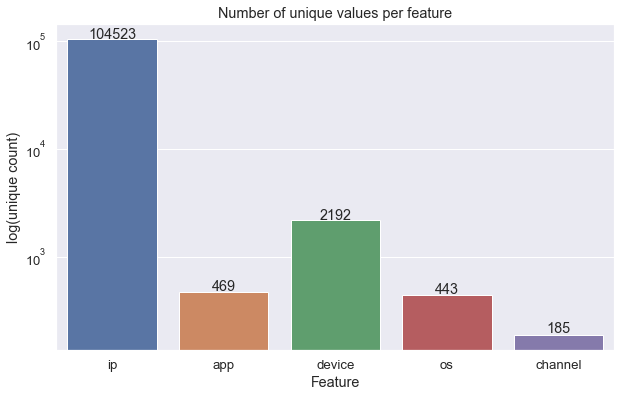

In [18]:
# Number of unique values per feature
plt.figure(figsize=(10, 6))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train_df[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', 
       title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 
# for col, uniq in zip(cols, uniques):
#     ax.text(col, uniq, uniq, color='black', ha="center")

### Target Variable

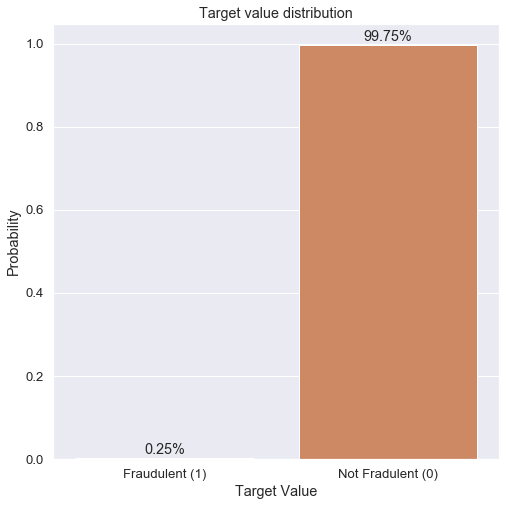

In [19]:
# Target value distribution
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.2)

mean = (train_df.is_attributed.values == 1).mean()
ax = sns.barplot(['Fraudulent (1)', 'Not Fradulent (0)'], [mean, 1-mean])
ax.set(xlabel='Target Value', ylabel='Probability', title='Target value distribution')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center") 

### IP

In [8]:
# Explore ip counts. Check if multiple ips have any downloads.
train_ip_count = train_df['ip'].value_counts().reset_index(name='counts')
train_ip_count.columns = ['ip', 'counts']
train_ip_count[:20]

,ip,counts
0,5348,318367
1,5314,284299
2,73516,155728
3,73487,154130
4,53454,116348
5,112302,114715
6,17149,113777
7,26995,97968
8,114276,95276
9,95766,90304


There are ip adresses that trigger a click over 50 thousand times. Seems strange that one ip address would click that often in a span of just 4 days. Does that mean that ip address encoded is not device id, but network id? (explore this below)

In [9]:
#add temporary counts of ip feature ('counts') to the train table, 
# to see if IPs with high counts have conversions
train_df= train_df.merge(train_ip_count, on='ip', how='left')

#check top 20 values
train_df[train_df['is_attributed']==1].sort_values('counts', ascending=False)[:10]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,counts
5199985,5348,19,0,24,347,2017-11-09 05:21:27,2017-11-09 05:21:45,1,318367
34226995,5348,29,1,13,210,2017-11-09 14:11:40,2017-11-09 14:11:43,1,318367
27602051,5348,8,1,19,145,2017-11-09 12:16:07,2017-11-09 12:16:40,1,318367
16441483,5348,24,1,1,178,2017-11-09 08:46:39,2017-11-09 09:33:01,1,318367
32302492,5348,18,1,19,107,2017-11-09 13:38:50,2017-11-09 13:39:00,1,318367
34210984,5348,19,0,21,213,2017-11-09 14:11:24,2017-11-09 14:11:26,1,318367
34211200,5348,19,0,50,213,2017-11-09 14:11:24,2017-11-09 14:11:25,1,318367
17644548,5348,136,0,21,268,2017-11-09 09:11:47,2017-11-09 09:17:27,1,318367
4740169,5348,19,0,0,347,2017-11-09 05:13:59,2017-11-09 05:14:05,1,318367
19870500,5348,19,0,0,347,2017-11-09 09:56:27,2017-11-09 09:56:42,1,318367


In [10]:
train_df[train_df['is_attributed']==1].ip.describe()

count     100508
unique     71178
top         5348
freq         525
Name: ip, dtype: object

So high frequency ip counts do get conversions. Up to 525 downloads for one ip. 
Each IP must be for some network with many devices.

### Conversoes

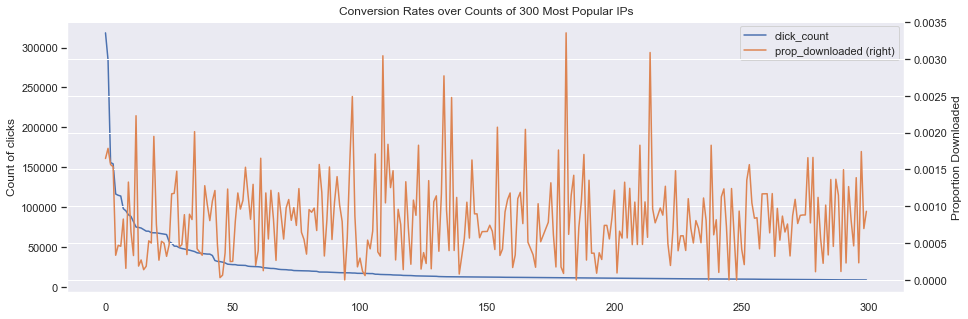

Counversion Rates over Counts of Most Popular IPs
        ip  click_count  prop_downloaded
0     5348       318367         0.001649
1     5314       284299         0.001787
2    73516       155728         0.001567
3    73487       154130         0.001538
4    53454       116348         0.000335
5   112302       114715         0.000471
6    17149       113777         0.000457
7    26995        97968         0.000827
8   114276        95276         0.000157
9    95766        90304         0.001329
10  105475        88315         0.000657
11  111025        81518         0.000331
12    5178        74893         0.002230
13   48282        74426         0.000188
14   48212        73660         0.000272
15   48240        71758         0.000139
16   48170        69796         0.000186
17  123994        69703         0.000531
18   53964        67800         0.000501
19    5147        67722         0.001949


In [22]:
# Conversion rates over Counts of 300 most popular IPs

proportion = train_df[['ip', 'is_attributed']].groupby('ip', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train_df[['ip', 'is_attributed']].groupby('ip', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='ip', how='left')
merge.columns = ['ip', 'click_count', 'prop_downloaded']

ax = merge[:300].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 300 Most Popular IPs')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular IPs')
print(merge[:20])

Conversions are noisy and do not appear to correlate with how popular an IP is.

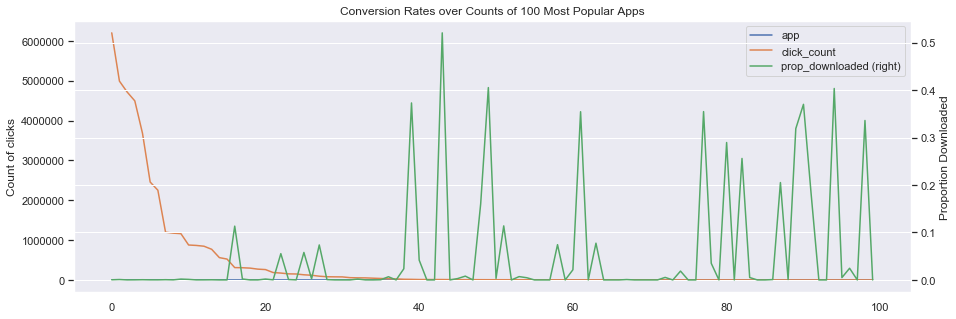

Counversion Rates over Counts of Most Popular Apps
    app  click_count  prop_downloaded
0     3      6198926         0.000353
1     9      4988050         0.000902
2    12      4715096         0.000095
3     2      4492746         0.000202
4    18      3679664         0.000477
5    15      2456056         0.000192
6    14      2251056         0.000182
7     7      1197652         0.000520
8     1      1174214         0.000169
9     8      1160988         0.001810
10   11       876600         0.001189
11   21       865804         0.000109
12   13       846179         0.000144
13   26       769155         0.000309
14   23       560269         0.000012
15    6       523461         0.000052
16   19       309709         0.113374
17   20       306400         0.002001
18   25       296794         0.000067
19   28       271231         0.000055


In [26]:
# Conversions by App

proportion = train_df[['app', 'is_attributed']].groupby('app', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train_df[['app', 'is_attributed']].groupby('app', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='app', how='left')
merge.columns = ['app', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Apps')
print(merge[:20])

There is a again a huge difference in clicks per app, with minimum of one click on an app and max at almost 62 million. The proportion flucuates more as the counts go down, since each additional click has larger impact on the proportion value. In general, for apps with counts in the thousands the ratio stays within 0.0001 - 0.0015 boundary. For less popular apps it fluxuates more widely.


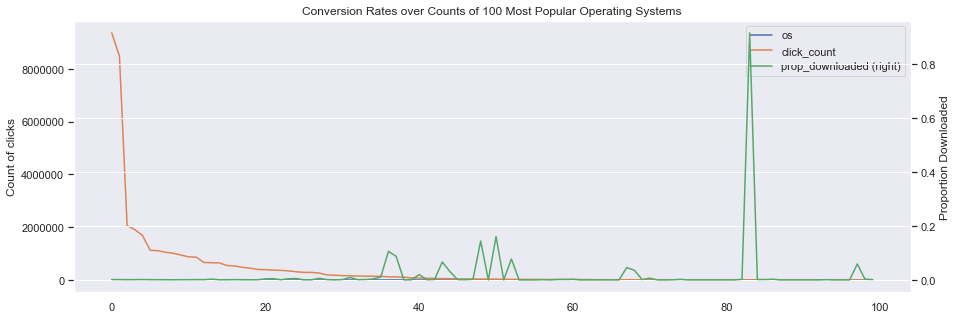

Counversion Rates over Counts of Most Popular Operating Systems
    os  click_count  prop_downloaded
0   19      9368370         0.001585
1   13      8482452         0.001324
2   17      2060435         0.000958
3   18      1909580         0.001143
4   22      1687180         0.001537
5    8      1124326         0.001014
6   10      1108894         0.001053
7    6      1050015         0.000723
8    9      1012393         0.000589
9   15       944682         0.000997
10  25       875382         0.001001
11  20       863280         0.001140
12  16       662965         0.001086
13  37       652363         0.003008
14   3       646240         0.000693
15  41       548915         0.000692
16  14       529470         0.001214
17   1       479722         0.000771
18  12       446294         0.000632
19  23       396295         0.000775


In [27]:
# Conversions by OS

proportion = train_df[['os', 'is_attributed']].groupby('os', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train_df[['os', 'is_attributed']].groupby('os', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='os', how='left')
merge.columns = ['os', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Operating Systems')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Operating Systems')
print(merge[:20])

Same story. For values in the thousands the boundary on the ratio is very low, roughly between 0.0006 and 0.003, but as counts on OS become lower, the ratio starts fluxuating more wildely.

In [28]:
# Conversions by Device

# Devices are extremely disproportionately distributed, with number one device used almost 94% of time. 
# For that device proportion download was 0.001638. (0.16%)

proportion = train_df[['device', 'is_attributed']].groupby('device', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train_df[['device', 'is_attributed']].groupby('device', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='device', how='left')
merge.columns = ['device', 'click_count', 'prop_downloaded']

print('Count of clicks and proportion of downloads by device:')
print(merge)

Count of clicks and proportion of downloads by device:
      device  click_count  prop_downloaded
0          1     37343882         0.001638
1          2      2120897         0.000284
2          0       324987         0.084274
3       3866       123387         0.000016
4          5        14379         0.000000
...      ...          ...              ...
2187    2554            1         0.000000
2188    2556            1         0.000000
2189    2562            1         0.000000
2190    2564            1         0.000000
2191    1385            1         0.000000

[2192 rows x 3 columns]


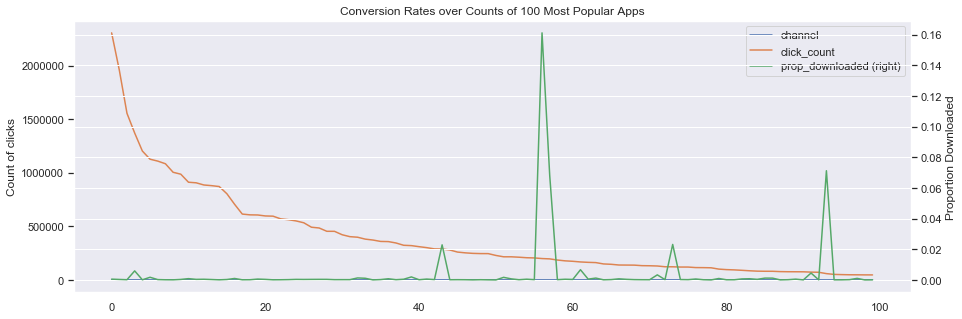

Counversion Rates over Counts of Most Popular Channels
    channel  click_count  prop_downloaded
0       107      2304914         0.000542
1       280      1957725         0.000343
2       477      1553942         0.000176
3       101      1370437         0.005925
4       265      1202495         0.000118
5       145      1126288         0.001758
6       259      1108626         0.000256
7       153      1083864         0.000133
8       178      1004345         0.000095
9       121       986516         0.000355
10      466       911547         0.000869
11      134       906112         0.000403
12      232       885865         0.000468
13      379       879660         0.000293
14      205       871322         0.000095
15      442       803867         0.000311
16      127       705560         0.000975
17      245       614486         0.000119
18      237       607232         0.000156
19      489       606053         0.000578


In [29]:
# Conversions by Channel

proportion = train_df[['channel', 'is_attributed']].groupby('channel', as_index=False).mean().sort_values('is_attributed', ascending=False)
counts = train_df[['channel', 'is_attributed']].groupby('channel', as_index=False).count().sort_values('is_attributed', ascending=False)
merge = counts.merge(proportion, on='channel', how='left')
merge.columns = ['channel', 'click_count', 'prop_downloaded']

ax = merge[:100].plot(secondary_y='prop_downloaded')
plt.title('Conversion Rates over Counts of 100 Most Popular Apps')
ax.set(ylabel='Count of clicks')
plt.ylabel('Proportion Downloaded')
plt.show()

print('Counversion Rates over Counts of Most Popular Channels')
print(merge[:20])

There appear to be a few peaks for channels at reasonable click quantity, but overall the pattern holds same as for categories above.